In [67]:
from transformers import LayoutLMv3Processor
import torch

processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


In [68]:
unique_labels = [
    "TABLE",
    "OTHER",
    "DATE",
    "NUMBER",
    "SELLER_ADDRESS",
    "TOTAL",
    "TITLE",
    "SELLER_NAME",
    "SUB_TOTAL",
    "BUYER",
    "DUE_DATE",
    "NOTE",
    "SELLER_EMAIL",
    "TOTAL_WORDS",
    "TAX",
    "PAYMENT_DETAILS",
    "CONDITIONS",
    "DISCOUNT",
    "SEND_TO",
    "BILL_TO",
    "PO_NUMBER",
    "SELLER_SITE",
    "GSTIN",
    "GSTIN_SELLER",
    "AMOUNT_DUE",
    "GSTIN_BUYER",
    "GST(18%)",
    "GST(9%)",
    "GST(1%)",
    "GST(12%)",
    "GST(20%)",
    "GST(5%)",
    "GST(7%)"
]

label_list = sorted(list(unique_labels)) 
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

In [69]:
from PIL import Image
import torch

def preprocess_v2_fixed(example):
    try:
        # Open image with error handling
        try:
            # Fix path separators (Windows vs Unix)
            image_path = example["image_path"].replace('\\', '/')
            image = Image.open(image_path).convert("RGB")
            
            # Check if image is reasonable size
            if image.width > 5000 or image.height > 5000:
                image = image.resize((min(image.width, 2000), min(image.height, 2000)))
        except Exception as e:
            print(f"Error loading image {example['image_path']}: {e}")
            # Return a minimal valid structure
            return {"input_ids": torch.zeros(384, dtype=torch.long), 
                   "attention_mask": torch.zeros(384, dtype=torch.long),
                   "labels": torch.zeros(384, dtype=torch.long)}
        
        # Validate bounding boxes and labels
        validated_boxes = []
        valid_words = []
        valid_labels = []
        
        for word, bbox, tag in zip(example["words"], example["bboxes"], example["ner_tags"]):
            try:
                # Ensure boxes are valid format
                if len(bbox) == 4:
                    # Ensure all values are integers and in valid range
                    validated_box = [max(0, min(int(coord), 1000)) for coord in bbox]
                    
                    # Ensure label is valid - convert to string if it's a number
                    if isinstance(tag, (int, float)):
                        tag = str(tag)
                    
                    # Check if label exists in label2id, otherwise use "OTHER"
                    if tag not in label2id:
                        print(f"Warning: Unknown label '{tag}', using 'OTHER' instead")
                        tag = "OTHER"
                    
                    validated_boxes.append(validated_box)
                    valid_words.append(word)
                    valid_labels.append(tag)
            except Exception as e:
                print(f"Error processing word/bbox/tag: {e}")
                continue
                
        # Skip if no valid data
        if not valid_words:
            print(f"No valid words found in {example['image_path']}")
            return {"input_ids": torch.zeros(384, dtype=torch.long), 
                   "attention_mask": torch.zeros(384, dtype=torch.long),
                   "labels": torch.zeros(384, dtype=torch.long)}
        
        # Process with reduced max_length to save memory
        try:
            encoding = processor(
                image,
                text=valid_words,
                boxes=validated_boxes,
                word_labels=[label2id.get(label, label2id["OTHER"]) for label in valid_labels],
                padding="max_length",
                truncation=True,
                max_length=384,  # Reduced from 512
                return_tensors="pt"
            )
            
            result = {k: v.squeeze(0) for k, v in encoding.items()}
        except Exception as e:
            print(f"Error in processor encoding: {e}")
            return {"input_ids": torch.zeros(384, dtype=torch.long), 
                   "attention_mask": torch.zeros(384, dtype=torch.long),
                   "labels": torch.zeros(384, dtype=torch.long)}
        
        # Clean up to free memory
        del image
        del encoding
        
        return result
        
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return {"input_ids": torch.zeros(384, dtype=torch.long), 
               "attention_mask": torch.zeros(384, dtype=torch.long),
               "labels": torch.zeros(384, dtype=torch.long)}

In [70]:
from datasets import Dataset
import os
import json

def load_fatura_dataset(json_dir):
    data = []
    for fname in os.listdir(json_dir):
        if fname.endswith(".json"):
            with open(os.path.join(json_dir, fname), "r", encoding="utf-8") as f:
                sample = json.load(f)
                data.append({
                    "words": sample["words"],
                    "bboxes": sample["bboxes"],
                    "ner_tags": sample["ner_tags"],
                    "image_path": os.path.join(json_dir, sample["path"])  # Full path to image
                })
    return Dataset.from_list(data)

# Example usage
dataset = load_fatura_dataset("invoices_dataset_final/Annotations/layoutlm_HF_format")


In [71]:
# Add this cell after cell 4 to fix the path issues
import os
import gc

# Define memory cleanup function that was referenced but missing
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Fix the dataset paths to ensure images can be found
def fix_dataset_paths(dataset):
    print("Fixing dataset paths...")
    new_data = []
    
    for item in dataset:
        # Extract image filename from original path
        image_path = item["image_path"]
        filename = os.path.basename(image_path)
        
        # Check if the file exists in different possible locations
        possible_paths = [
            # Original path
            image_path,
            # Path using parent directory
            os.path.join(os.path.dirname(os.path.dirname(image_path)), "images", filename),
            # Path using direct folder
            os.path.join("invoices_dataset_final/images", filename),
            # Path without annotations subfolder
            os.path.join("invoices_dataset_final", filename)
        ]
        
        valid_path = None
        for path in possible_paths:
            if os.path.exists(path):
                valid_path = path
                break
        
        if valid_path:
            item["image_path"] = valid_path
            new_data.append(item)
        else:
            print(f"Warning: Could not find image for {filename}")
    
    return Dataset.from_list(new_data)

# Apply the fix to your dataset
dataset = fix_dataset_paths(dataset)
print(f"Dataset after fixing paths: {len(dataset)} valid samples")

Fixing dataset paths...
Dataset after fixing paths: 10000 valid samples


In [72]:
# Add this cell to fix numeric labels in the dataset
print("Converting numeric labels to text labels...")

# Check first sample to confirm format
print(f"Sample ner_tags (first 5): {dataset[0]['ner_tags'][:5]}")

# Create a mapping from numeric labels to text labels
# This assumes that the numeric labels are indices into your label_list
numeric_to_text = {idx: label for idx, label in id2label.items()}

# Function to convert numeric labels in a sample
def convert_numeric_labels(sample):
    new_labels = []
    for tag in sample["ner_tags"]:
        # If it's numeric, convert to text using mapping
        if isinstance(tag, (int, float)) or (isinstance(tag, str) and tag.isdigit()):
            tag = int(tag)
            # Use "OTHER" as default if the index is out of range
            if tag < 0 or tag >= len(label_list):
                text_label = "OTHER"
                print(f"Warning: Label index {tag} out of range, using 'OTHER'")
            else:
                text_label = label_list[tag]
            new_labels.append(text_label)
        else:
            # Already a text label
            new_labels.append(tag)
    
    # Replace the labels in the sample
    sample["ner_tags"] = new_labels
    return sample

# Apply the conversion to the dataset
dataset = dataset.map(convert_numeric_labels)

# Check if labels are now text
print("Checking converted labels...")
all_labels = set()
for sample in dataset:
    all_labels.update(sample["ner_tags"])

print(f"Number of unique labels after conversion: {len(all_labels)}")
print(f"Sample labels: {list(all_labels)[:10]}")

Converting numeric labels to text labels...
Sample ner_tags (first 5): [10, 5, 5, 5, 5]


Map: 100%|██████████| 10000/10000 [00:01<00:00, 6225.02 examples/s]


Checking converted labels...
Number of unique labels after conversion: 13
Sample labels: ['GST(20%)', 'BUYER', 'AMOUNT_DUE', 'DATE', 'GST(18%)', 'DISCOUNT', 'GST(9%)', 'GST(12%)', 'CONDITIONS', 'GST(7%)']


In [ ]:
# Replace cell 6 (the training cell) with:
from transformers import LayoutLMv3ForTokenClassification, Trainer, TrainingArguments
from transformers import default_data_collator
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import torch
import os

# Enable better CUDA error messages
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# First, apply preprocessing to your dataset with lower memory usage
# First, check your dataset for invalid labels
print("Checking dataset for invalid labels...")
all_labels = set()
numeric_labels = []
for sample in dataset:
    for label in sample["ner_tags"]:
        all_labels.add(label)
        if isinstance(label, (int, float)) or label.isdigit():
            numeric_labels.append(label)

invalid_labels = [label for label in all_labels if label not in label2id]
if invalid_labels:
    print(f"Found {len(invalid_labels)} invalid labels: {invalid_labels[:10]}...")
if numeric_labels:
    print(f"Found {len(numeric_labels)} numeric labels: {numeric_labels[:10]}...")

# Now apply preprocessing with the fixed function
print("Preprocessing dataset...")
processed_dataset = dataset.map(
    preprocess_v2_fixed,  # Use the fixed function
    num_proc=1,  # Process one at a time to avoid memory spikes
    batch_size=1,  # Process items individually
    desc="Processing images"
)
# Clear memory after preprocessing
clear_memory()

# Remove columns we don't need anymore to save memory
columns_to_remove = ["words", "bboxes", "ner_tags", "image_path"]
processed_dataset = processed_dataset.remove_columns(columns_to_remove)

# Set format for PyTorch
processed_dataset.set_format("torch")

# Check the preprocessed data structure
print("Processed dataset features:", processed_dataset.features)
print("First sample keys:", list(processed_dataset[0].keys()) if len(processed_dataset) > 0 else "No samples")

# Split into training and validation
train_size = int(0.9 * len(processed_dataset))
val_size = len(processed_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    processed_dataset, [train_size, val_size]
)

print(f"Training with {len(train_dataset)} samples, validating with {len(val_dataset)} samples")

# Create data loaders with proper error handling - smaller batch size
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,  # Use batch size of 1 to avoid memory issues
    shuffle=True,
    collate_fn=default_data_collator
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,  # Use batch size of 1 to avoid memory issues
    shuffle=False,
    collate_fn=default_data_collator
)

Checking dataset for invalid labels...
Preprocessing dataset...


Processing images: 100%|██████████| 10000/10000 [06:23<00:00, 26.07 examples/s] 


Processed dataset features: {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None)}
First sample keys: ['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values']
Training with 9000 samples, validating with 1000 samples
Using device: cuda


TypeError: LayoutLMv3ForTokenClassification.__init__() got an unexpected keyword argument 'use_cache'

In [75]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model with gradient checkpointing for memory efficiency
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
).to(device)


# Use mixed precision training if CUDA is available
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler() if torch.cuda.is_available() else None

optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * 3  # 3 epochs
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=total_steps)

# Training loop with improved error handling and memory efficiency
model.train()
for epoch in range(3):
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    
    for step, batch in enumerate(progress_bar):
        try:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass with mixed precision
            if scaler is not None:
                with autocast():
                    outputs = model(**batch)
                    loss = outputs.loss
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Forward pass without mixed precision
                outputs = model(**batch)
                loss = outputs.loss
                
                # Backward pass
                loss.backward()
                optimizer.step()
            
            scheduler.step()
            optimizer.zero_grad()
            
            # Update progress
            total_loss += loss.item()
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
            
            # Free up memory
            del outputs
            del loss
            
            # Every 50 steps, clear memory aggressively
            if step % 50 == 0:
                clear_memory()
                
        except Exception as e:
            print(f"Error in batch {step}: {e}")
            clear_memory()  # Clear memory after error
            continue
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader, desc="Validation"):
            try:
                val_batch = {k: v.to(device) for k, v in val_batch.items()}
                val_outputs = model(**val_batch)
                val_loss += val_outputs.loss.item()
                
                # Free memory
                del val_outputs
            except Exception as e:
                print(f"Error in validation: {e}")
                continue
    
    clear_memory()  # Clear memory after validation
    
    print(f"Epoch {epoch + 1} | Train Loss: {total_loss / len(train_dataloader):.4f} | Val Loss: {val_loss / len(val_dataloader):.4f}")
    model.train()

# Save the model
output_dir = "models/layoutlm_finetuned"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

Using device: cuda


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vshug\AppData\Local\Temp\ipykernel_36336\3842734522.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if torch.cuda.is_available() else None
Epoch 1:   0%|          | 0/9000 [00:00<?, ?it/s]C:\Users\vshug\AppData\Local\Temp\ipykernel_36336\3842734522.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\vshug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-pac

Epoch 1 | Train Loss: 0.0396 | Val Loss: 0.0005


Validation: 100%|██████████| 1000/1000 [01:51<00:00,  8.96it/s]


Epoch 2 | Train Loss: 0.0043 | Val Loss: 0.0006


Validation: 100%|██████████| 1000/1000 [01:35<00:00, 10.46it/s]


Epoch 3 | Train Loss: 0.0047 | Val Loss: 0.0002
Model saved to models/layoutlm_finetuned


Evaluating model on validation set...


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\vshug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\transformers\modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Evaluating: 100%|██████████| 1000/1000 [00:57<00:00, 17.24it/s]


Found 13 classes in the evaluation data
Overall metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000

F1 scores for key classes:
  AMOUNT_DUE: 1.0000
  BILL_TO: 1.0000
  BUYER: 1.0000
  CONDITIONS: 1.0000
  DATE: 1.0000
  DISCOUNT: 1.0000
  DUE_DATE: 1.0000
  GST(12%): 1.0000
  GST(18%): 1.0000


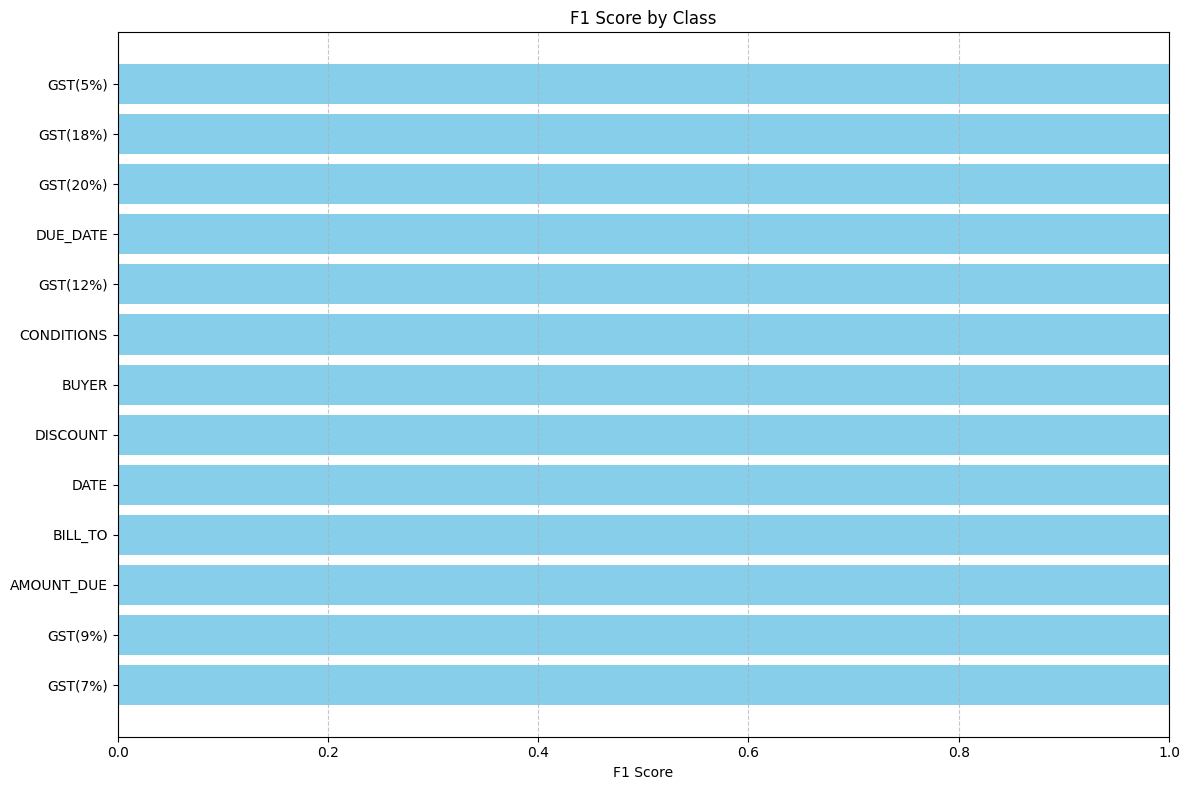

In [77]:
# Cell for evaluation metrics and F1 score calculation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
import numpy as np

def compute_metrics(model, dataloader, device):
    """Compute metrics (precision, recall, F1) on the provided dataloader"""
    model.eval()
    
    # Initialize lists to store predictions and true labels
    all_predictions = []
    all_labels = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            try:
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items()}
                
                # Forward pass
                outputs = model(**batch)
                logits = outputs.logits
                
                # Get predictions - token classification is done at the token level
                predictions = torch.argmax(logits, dim=-1).detach().cpu().numpy()
                labels = batch["labels"].detach().cpu().numpy()
                
                # Mask out padding tokens (usually labeled as -100)
                valid_mask = labels != -100
                
                # Collect predictions and labels for valid tokens only
                for pred, label, mask in zip(predictions, labels, valid_mask):
                    all_predictions.extend(pred[mask].tolist())
                    all_labels.extend(label[mask].tolist())
                    
            except Exception as e:
                print(f"Error in evaluation: {e}")
                continue
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted'
    )
    accuracy = accuracy_score(all_labels, all_predictions)
    
    # Find the unique classes actually present in the predictions and labels
    unique_classes = sorted(set(all_predictions + all_labels))
    present_labels = [id2label[i] for i in unique_classes if i in id2label]
    
    print(f"Found {len(unique_classes)} classes in the evaluation data")
    
    # Generate per-class metrics with only the labels that are present
    class_report = classification_report(
        all_labels, 
        all_predictions,
        labels=unique_classes,  # Only use labels that are actually present
        target_names=present_labels,
        output_dict=True
    )
    
    # Store the actual labels used for visualization
    actual_labels = {i: id2label.get(i, f"Unknown-{i}") for i in unique_classes}
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "class_report": class_report,
        "actual_labels": actual_labels
    }

# Evaluate the model on validation set
print("Evaluating model on validation set...")
eval_metrics = compute_metrics(model, val_dataloader, device)

# Print results
print(f"Overall metrics:")
print(f"  Accuracy:  {eval_metrics['accuracy']:.4f}")
print(f"  Precision: {eval_metrics['precision']:.4f}")
print(f"  Recall:    {eval_metrics['recall']:.4f}")
print(f"  F1 Score:  {eval_metrics['f1']:.4f}")

# Print per-class F1 scores for the most important classes
print("\nF1 scores for key classes:")
for label in sorted(unique_labels)[:10]:  # Show first 10 classes
    if label in eval_metrics['class_report']:
        print(f"  {label}: {eval_metrics['class_report'][label]['f1-score']:.4f}")

# Create and save visualization
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    # Plot F1 scores for each class
    class_metrics = metrics['class_report']
    actual_labels = metrics['actual_labels']
    class_names = []
    f1_scores = []
    
    for label, values in class_metrics.items():
        if label in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        # Use the class name or the label index if the name isn't available
        if isinstance(label, str) and label.isdigit():
            label = int(label)
        
        class_name = actual_labels.get(label, str(label))
        class_names.append(class_name)
        f1_scores.append(values['f1-score'])
    
    # Sort by F1 score
    sorted_indices = np.argsort(f1_scores)
    class_names = [class_names[i] for i in sorted_indices]
    f1_scores = [f1_scores[i] for i in sorted_indices]
    
    plt.barh(class_names, f1_scores, color='skyblue')
    plt.xlabel('F1 Score')
    plt.title('F1 Score by Class')
    plt.xlim(0, 1.0)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig("f1_scores_by_class.png")
    plt.show()

# Plot the results
plot_metrics(eval_metrics)